# Predicting Return and Volatility Distributions

**Objective**: Demonstrate that machine learning can predict the *distribution* of short-term returns and volatility - not just point estimates, but calibrated prediction intervals that quantify uncertainty.

**Key Questions**:
1. Can we predict the distribution of future returns? (Yes - with appropriately wide, well-calibrated intervals)
2. Can we predict the distribution of future volatility? (Yes - with tighter, informative intervals)

**Key Insight**: The model "knows what it doesn't know":
- For **returns**: Prediction intervals are wide and centered near zero → model correctly captures that point predictions are unreliable
- For **volatility**: Prediction intervals are narrower and track actual values → model provides actionable forecasts

**Methodology**:
- **Year-by-year walk-forward CV**: Train on 2016, test on 2017 → Train on 2016-2017, test on 2018 → ... → Train on 2016-2023, test on 2024
- **True out-of-sample**: Final model trained on 2016-2024, tested on 2025
- **Universe**: QQQ and top 10 holdings (high-volatility tech stocks)

## Table of Contents
1. [Data Loading](#1-data-loading)
2. [Exploratory Data Analysis](#2-eda)
3. [Preprocessing & Walk-Forward Setup](#3-preprocessing)
4. [Point Prediction Baselines](#4-baselines)
   - 4.1 [Hyperparameter Tuning](#4-baselines)
5. [Distribution Prediction (Main Results)](#5-distribution)
6. [Out-of-Sample Validation (2025)](#6-oos)
7. [Model Diagnostics](#7-diagnostics)
8. [Error Analysis](#8-error)
9. [Appendix: Trading Strategy](#9-appendix)
10. [Conclusions](#10-conclusions)

<a id="1-data-loading"></a>
## 1. Data Loading

Load OHLCV data for QQQ and top 10 holdings from Yahoo Finance, then compute technical features using our feature engineering module.

In [1]:
# Data Loading
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from src.data import compute_all, get_features

TICKERS = ['QQQ', 'NVDA', 'MSFT', 'AAPL', 'AVGO', 'AMZN', 'TSLA', 'META', 'GOOGL', 'GOOG', 'NFLX']
START, END = '2015-01-01', '2025-12-01'

dfs = []
for ticker in TICKERS:
    data = yf.download(ticker, start=START, end=END, progress=False, multi_level_index=False)
    ticker_df = compute_all(data, ticker=ticker)
    
    core_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    feature_cols = [c for c in ticker_df.columns if c not in core_cols + ['Date']]
    ticker_df[feature_cols] = ticker_df[feature_cols].ffill()
    ticker_df = ticker_df.dropna(subset=core_cols + ['target_ret_1d', 'target_vol_1d'])
    
    ticker_df = ticker_df.reset_index()
    ticker_df['ticker'] = ticker
    dfs.append(ticker_df)

df_raw = pd.concat(dfs, ignore_index=True).sort_values(['Date', 'ticker']).reset_index(drop=True)
df_raw['year'] = df_raw['Date'].dt.year
df = df_raw[df_raw['year'] >= 2016].copy().reset_index(drop=True)

print(f"Total samples: {len(df):,} | Tickers: {len(TICKERS)} | Date range: {df['Date'].min().strftime('%Y-%m-%d')} to {df['Date'].max().strftime('%Y-%m-%d')}")

Computing features...
  Adding price-based features...
  Adding VIX features...
  Adding CBOE features...
  Adding fixed income features...
  Adding cross-asset features...
  Adding sector features...
  Computing targets...
  Total columns: 119
Computing features...
  Adding price-based features...
  Adding VIX features...
  Adding CBOE features...
  Adding fixed income features...
  Adding cross-asset features...
  Adding sector features...
  Computing targets...
  Total columns: 119
Computing features...
  Adding price-based features...
  Adding VIX features...
  Adding CBOE features...
  Adding fixed income features...
  Adding cross-asset features...
  Adding sector features...
  Computing targets...
  Total columns: 119
Computing features...
  Adding price-based features...
  Adding VIX features...
  Adding CBOE features...
  Adding fixed income features...
  Adding cross-asset features...
  Adding sector features...
  Computing targets...
  Total columns: 119
Computing features..

<a id="2-eda"></a>
## 2. Exploratory Data Analysis

Examine feature distributions, target statistics, and correlations.

In [2]:
# Dataset Overview
feature_cols = [c for c in get_features(df) if c != 'ticker']
target_cols = [c for c in df.columns if c.startswith('target_')]

print(f"Samples: {len(df):,} | Features: {len(feature_cols)} | Targets: {len(target_cols)} | Tickers: {df['ticker'].nunique()}")
print(f"\nSamples per year:")
print(df.groupby('year').size().to_string())

Samples: 27,412 | Features: 109 | Targets: 6 | Tickers: 11

Samples per year:
year
2016    2772
2017    2761
2018    2761
2019    2772
2020    2783
2021    2772
2022    2761
2023    2750
2024    2772
2025    2508


In [3]:
# Target Statistics - Including Higher Moments
from scipy.stats import skew, kurtosis

target_stats = []
for col in ['target_ret_1d', 'target_ret_5d', 'target_vol_1d', 'target_vol_5d']:
    data = df[col].dropna()
    target_stats.append({
        'Target': col.replace('target_', ''),
        'Mean': data.mean(),
        'Std': data.std(),
        'Min': data.min(),
        'Max': data.max(),
        'Skewness': skew(data),
        'Kurtosis': kurtosis(data)
    })

stats_df = pd.DataFrame(target_stats)
print("Target Variable Statistics:")
print(f"{'Target':<10} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10} {'Skew':>8} {'Kurt':>8}")
print("-" * 68)
for _, row in stats_df.iterrows():
    print(f"{row['Target']:<10} {row['Mean']:>10.4f} {row['Std']:>10.4f} {row['Min']:>10.4f} {row['Max']:>10.4f} {row['Skewness']:>8.2f} {row['Kurtosis']:>8.2f}")

print("\nKey Observations:")
print("  • Returns have high kurtosis (fat tails) - extreme events more frequent than normal distribution")
print("  • Volatility is right-skewed - occasional large spikes")
print("  • Return skewness near 0 but kurtosis >> 0 indicates symmetric but heavy-tailed distribution")

Target Variable Statistics:
Target           Mean        Std        Min        Max     Skew     Kurt
--------------------------------------------------------------------
ret_1d         0.0014     0.0237    -0.3512     0.2981     0.18    12.64
ret_5d         0.0068     0.0518    -0.4309     0.5648     0.36     6.47
vol_1d         0.0157     0.0179     0.0000     0.3512     3.71    27.60
vol_5d         0.0192     0.0143     0.0007     0.1603     2.63    12.13

Key Observations:
  • Returns have high kurtosis (fat tails) - extreme events more frequent than normal distribution
  • Volatility is right-skewed - occasional large spikes
  • Return skewness near 0 but kurtosis >> 0 indicates symmetric but heavy-tailed distribution


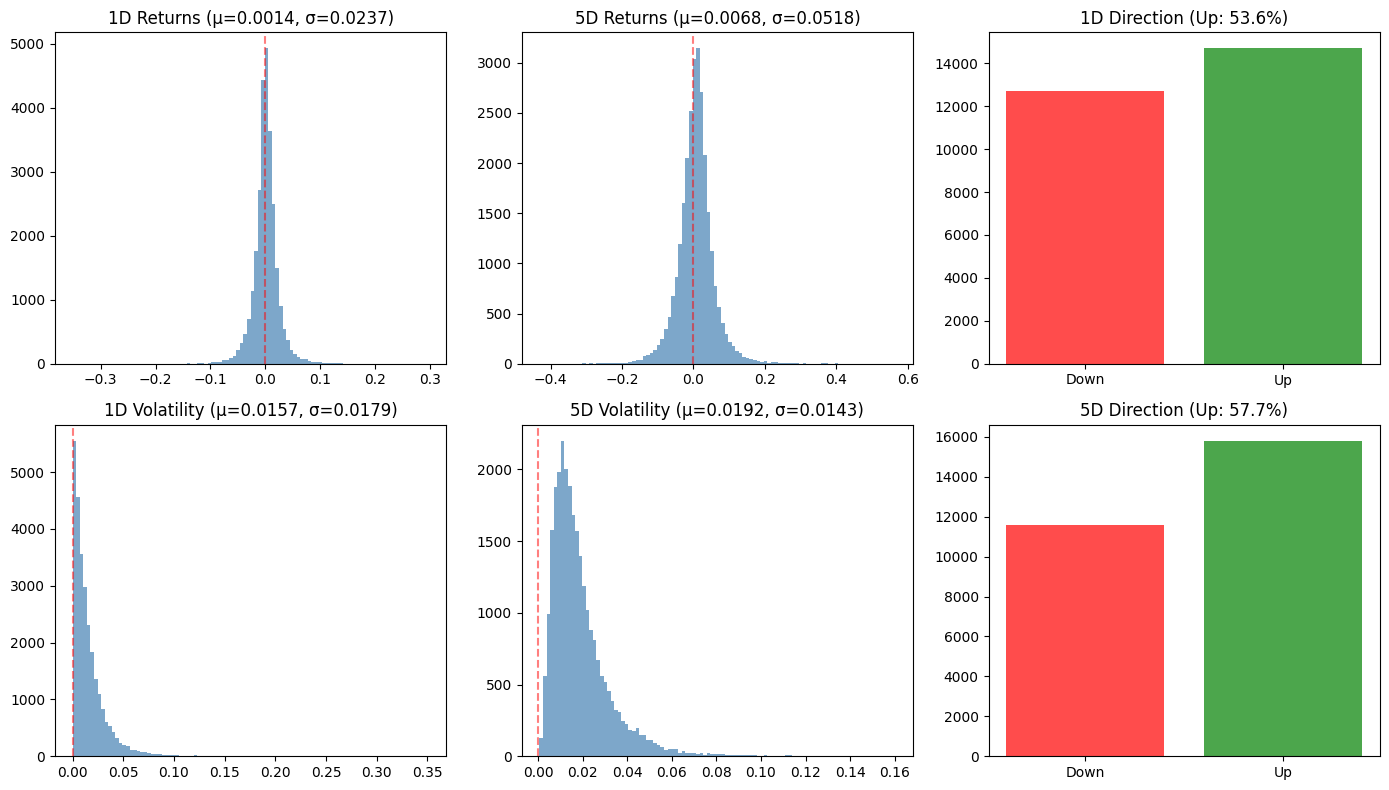

In [4]:
# Target Distributions
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

targets_to_plot = ['target_ret_1d', 'target_ret_5d', 'target_dir_1d', 
                   'target_vol_1d', 'target_vol_5d', 'target_dir_5d']
titles = ['1D Returns', '5D Returns', '1D Direction', '1D Volatility', '5D Volatility', '5D Direction']

for ax, col, title in zip(axes.flatten(), targets_to_plot, titles):
    if 'dir' in col:
        counts = df[col].value_counts().sort_index()
        ax.bar(['Down', 'Up'], counts.values, color=['red', 'green'], alpha=0.7)
        ax.set_title(f'{title} (Up: {df[col].mean():.1%})')
    else:
        ax.hist(df[col].dropna(), bins=100, alpha=0.7, color='steelblue', edgecolor='none')
        ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)
        ax.set_title(f'{title} (μ={df[col].mean():.4f}, σ={df[col].std():.4f})')

plt.tight_layout()
plt.show()

In [5]:
# Top Features Correlated with Volatility
vol_features = [c for c in feature_cols if c.startswith('vol_') or c.startswith('vix_')]
corr_with_vol1d = df[vol_features + ['target_vol_1d']].corr()['target_vol_1d'].drop('target_vol_1d').sort_values(ascending=False)

print("Top 10 features correlated with 1D volatility:")
print(corr_with_vol1d.head(10).to_string())

Top 10 features correlated with 1D volatility:
vol_atr_pct         0.404135
vol_garman_klass    0.385238
vol_parkinson       0.383283
vol_hist_20         0.342585
vol_hist_10         0.340590
vol_hist_5          0.315563
vol_bb_width        0.310629
vix_close           0.298374
vix_sma_10          0.260414
vix_sma_20          0.222746


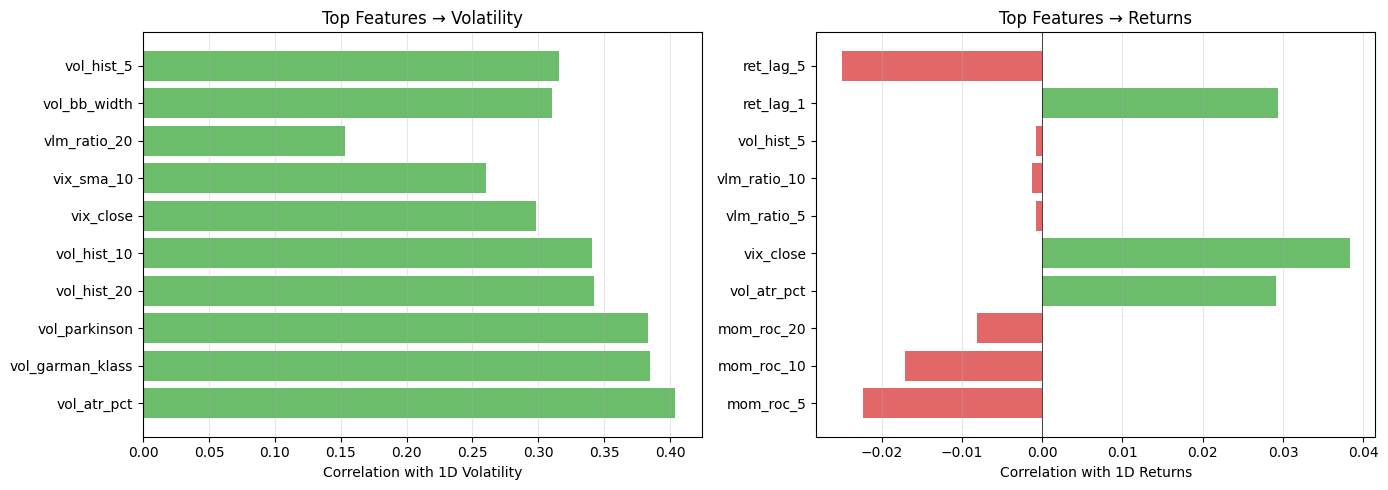

Key Insight: Volatility features strongly correlate with future volatility (0.3-0.4),
but NO features meaningfully correlate with future returns (<0.05). This is why vol is predictable but returns aren't.


In [6]:
# Feature-Target Correlation Heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Select top features for visualization (using features that exist in the dataset)
top_vol_features = ['vol_atr_pct', 'vol_garman_klass', 'vol_parkinson', 'vol_hist_20', 'vol_hist_10', 
                    'vix_close', 'vix_sma_10', 'vlm_ratio_20', 'vol_bb_width', 'vol_hist_5']
top_ret_features = ['mom_roc_5', 'mom_roc_10', 'mom_roc_20', 'vol_atr_pct', 'vix_close',
                    'vlm_ratio_5', 'vlm_ratio_10', 'vol_hist_5', 'ret_lag_1', 'ret_lag_5']

# Volatility correlations
vol_corr = df[top_vol_features + ['target_vol_1d']].corr()['target_vol_1d'].drop('target_vol_1d')
ax = axes[0]
colors = ['#2ca02c' if v > 0 else '#d62728' for v in vol_corr.values]
bars = ax.barh(range(len(vol_corr)), vol_corr.values, color=colors, alpha=0.7)
ax.set_yticks(range(len(vol_corr)))
ax.set_yticklabels(vol_corr.index)
ax.set_xlabel('Correlation with 1D Volatility')
ax.set_title('Top Features → Volatility')
ax.axvline(x=0, color='black', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='x')

# Return correlations
ret_corr = df[top_ret_features + ['target_ret_1d']].corr()['target_ret_1d'].drop('target_ret_1d')
ax = axes[1]
colors = ['#2ca02c' if v > 0 else '#d62728' for v in ret_corr.values]
ax.barh(range(len(ret_corr)), ret_corr.values, color=colors, alpha=0.7)
ax.set_yticks(range(len(ret_corr)))
ax.set_yticklabels(ret_corr.index)
ax.set_xlabel('Correlation with 1D Returns')
ax.set_title('Top Features → Returns')
ax.axvline(x=0, color='black', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("Key Insight: Volatility features strongly correlate with future volatility (0.3-0.4),")
print("but NO features meaningfully correlate with future returns (<0.05). This is why vol is predictable but returns aren't.")

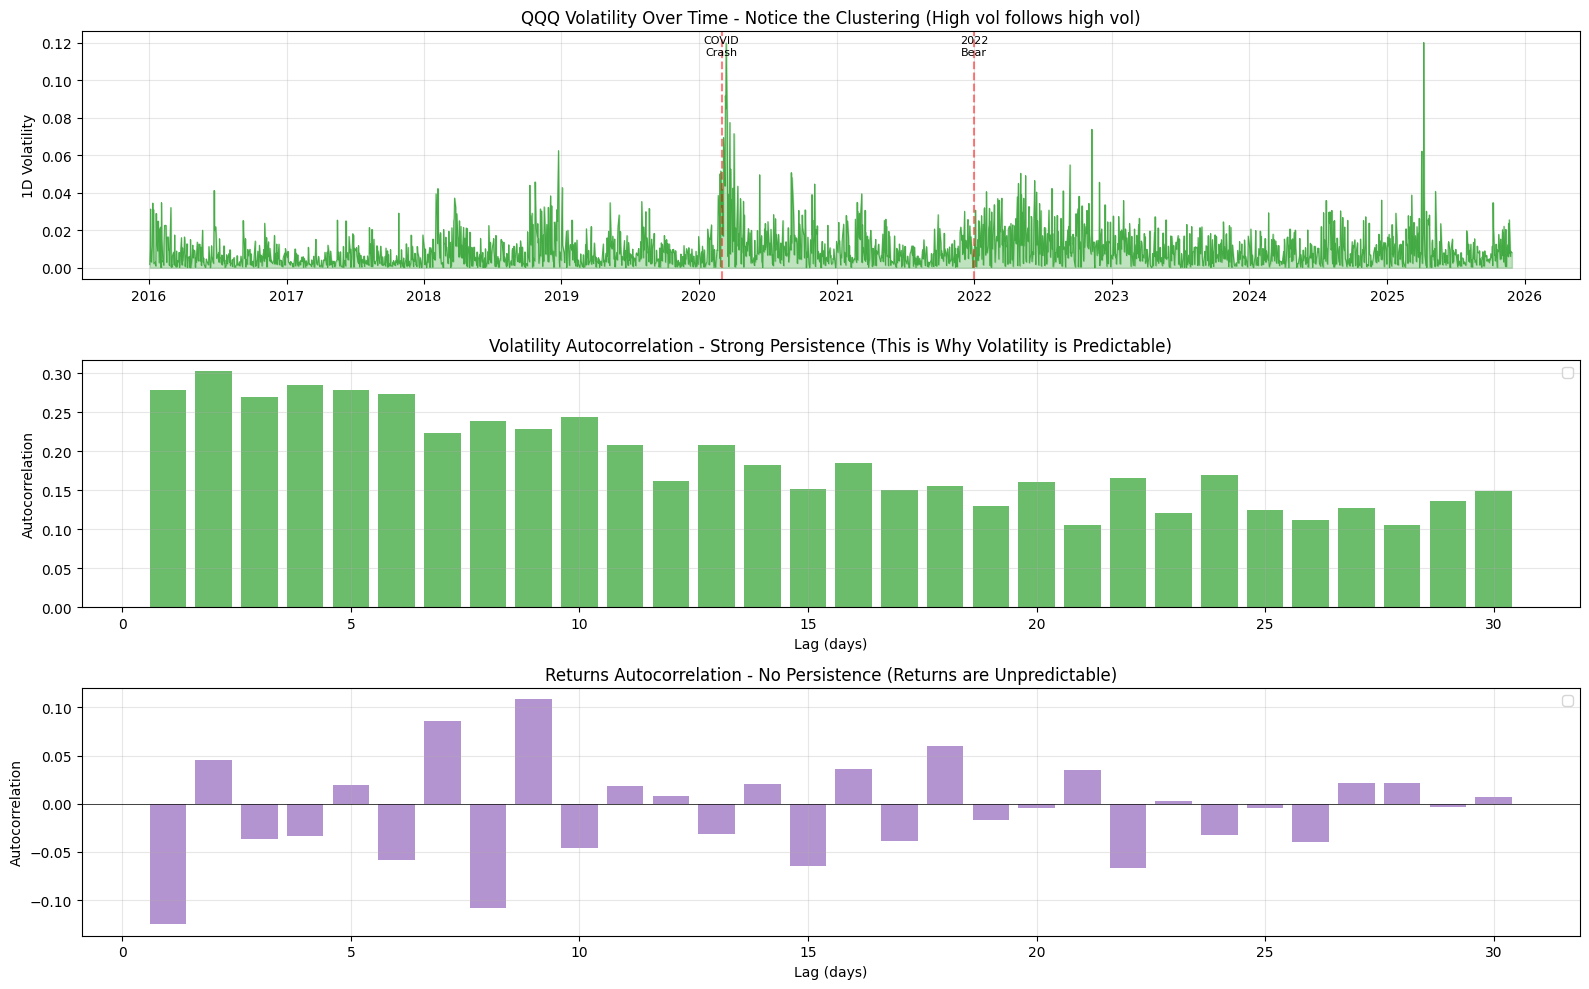

Volatility autocorrelation at lag 1: 0.278 (strong persistence)
Returns autocorrelation at lag 1: -0.125 (essentially zero)

This is the fundamental insight: volatility clusters, returns don't.


In [7]:
# Volatility Clustering Visualization - The Key Phenomenon
qqq = df[df['ticker'] == 'QQQ'].sort_values('Date').copy()

fig, axes = plt.subplots(3, 1, figsize=(16, 10))

# 1. Volatility time series
ax = axes[0]
ax.plot(qqq['Date'], qqq['target_vol_1d'], color='#2ca02c', linewidth=0.8, alpha=0.8)
ax.fill_between(qqq['Date'], 0, qqq['target_vol_1d'], alpha=0.3, color='#2ca02c')
ax.set_ylabel('1D Volatility')
ax.set_title('QQQ Volatility Over Time - Notice the Clustering (High vol follows high vol)')
ax.grid(True, alpha=0.3)

# Mark major events
events = [('2020-03', 'COVID\nCrash'), ('2022-01', '2022\nBear')]
for date, label in events:
    ax.axvline(pd.to_datetime(date), color='red', linestyle='--', alpha=0.5)
    ax.text(pd.to_datetime(date), ax.get_ylim()[1]*0.9, label, fontsize=8, ha='center')

# 2. Autocorrelation of volatility
ax = axes[1]
vol_series = qqq['target_vol_1d'].dropna()
lags = range(1, 31)
autocorrs = [vol_series.autocorr(lag=lag) for lag in lags]
ax.bar(lags, autocorrs, color='#2ca02c', alpha=0.7)
ax.axhline(y=0, color='black', linewidth=0.5)
#ax.axhline(y=1.96/np.sqrt(len(vol_series)), color='red', linestyle='--', alpha=0.5, label='95% CI')
#ax.axhline(y=-1.96/np.sqrt(len(vol_series)), color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Autocorrelation')
ax.set_title('Volatility Autocorrelation - Strong Persistence (This is Why Volatility is Predictable)')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Compare to returns autocorrelation
ax = axes[2]
ret_series = qqq['target_ret_1d'].dropna()
ret_autocorrs = [ret_series.autocorr(lag=lag) for lag in lags]
ax.bar(lags, ret_autocorrs, color='#9467bd', alpha=0.7)
ax.axhline(y=0, color='black', linewidth=0.5)
#ax.axhline(y=1.96/np.sqrt(len(ret_series)), color='red', linestyle='--', alpha=0.5, label='95% CI')
#ax.axhline(y=-1.96/np.sqrt(len(ret_series)), color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Autocorrelation')
ax.set_title('Returns Autocorrelation - No Persistence (Returns are Unpredictable)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Volatility autocorrelation at lag 1: {vol_series.autocorr(lag=1):.3f} (strong persistence)")
print(f"Returns autocorrelation at lag 1: {ret_series.autocorr(lag=1):.3f} (essentially zero)")
print("\nThis is the fundamental insight: volatility clusters, returns don't.")

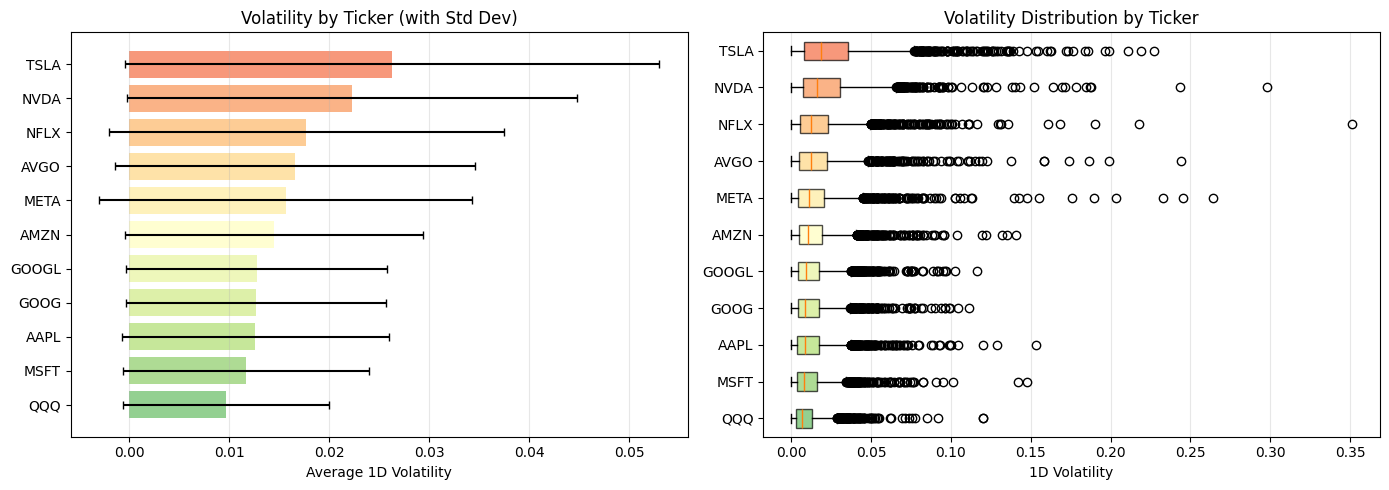

Observations:
  • Most volatile: TSLA (avg vol: 0.0263)
  • Least volatile: QQQ (avg vol: 0.0097)
  • Volatility spread: 2.7x difference between most/least volatile
  • High-vol stocks (TSLA, NVDA) have wider distributions - more extreme events


In [8]:
# Per-Ticker Volatility Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Average volatility by ticker
ticker_vol = df.groupby('ticker')['target_vol_1d'].agg(['mean', 'std']).sort_values('mean', ascending=True)
ax = axes[0]
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(ticker_vol)))
bars = ax.barh(range(len(ticker_vol)), ticker_vol['mean'], xerr=ticker_vol['std'], 
               color=colors, alpha=0.7, capsize=3)
ax.set_yticks(range(len(ticker_vol)))
ax.set_yticklabels(ticker_vol.index)
ax.set_xlabel('Average 1D Volatility')
ax.set_title('Volatility by Ticker (with Std Dev)')
ax.grid(True, alpha=0.3, axis='x')

# 2. Volatility distribution boxplot
ax = axes[1]
ticker_order = ticker_vol.index.tolist()
box_data = [df[df['ticker'] == t]['target_vol_1d'].dropna().values for t in ticker_order]
bp = ax.boxplot(box_data, labels=ticker_order, vert=False, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.set_xlabel('1D Volatility')
ax.set_title('Volatility Distribution by Ticker')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("Observations:")
print(f"  • Most volatile: {ticker_vol.index[-1]} (avg vol: {ticker_vol['mean'].iloc[-1]:.4f})")
print(f"  • Least volatile: {ticker_vol.index[0]} (avg vol: {ticker_vol['mean'].iloc[0]:.4f})")
print(f"  • Volatility spread: {ticker_vol['mean'].iloc[-1] / ticker_vol['mean'].iloc[0]:.1f}x difference between most/least volatile")
print("  • High-vol stocks (TSLA, NVDA) have wider distributions - more extreme events")

<a id="3-preprocessing"></a>
## 3. Preprocessing & Walk-Forward Setup

Prepare features, handle missing values, and create **year-by-year walk-forward splits**:

| Split | Train Years | Test Year |
|-------|-------------|-----------|
| 1 | 2016 | 2017 |
| 2 | 2016-2017 | 2018 |
| 3 | 2016-2018 | 2019 |
| ... | ... | ... |
| 8 | 2016-2023 | 2024 |
| **OOS** | **2016-2024** | **2025** |

This mimics real-world usage: train on all available history, predict next year.

In [9]:
# Create CV/OOS Splits and Feature Matrix
from sklearn.preprocessing import StandardScaler

QUANTILES = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]

df_cv = df[df['year'] <= 2024].copy().reset_index(drop=True)
df_oos = df[df['year'] == 2025].copy().reset_index(drop=True)

feature_cols = [c for c in get_features(df_cv) if c != 'ticker']
X = df_cv[feature_cols].fillna(0).values
vol_idx = feature_cols.index('vol_hist_20')
targets = {k: df_cv[f'target_{k}'].values for k in ['ret_1d', 'ret_5d', 'dir_1d', 'dir_5d', 'vol_1d', 'vol_5d']}

print(f"CV: {len(df_cv):,} samples (2016-2024) | OOS: {len(df_oos):,} samples (2025) | Features: {len(feature_cols)}")

CV: 24,904 samples (2016-2024) | OOS: 2,508 samples (2025) | Features: 109


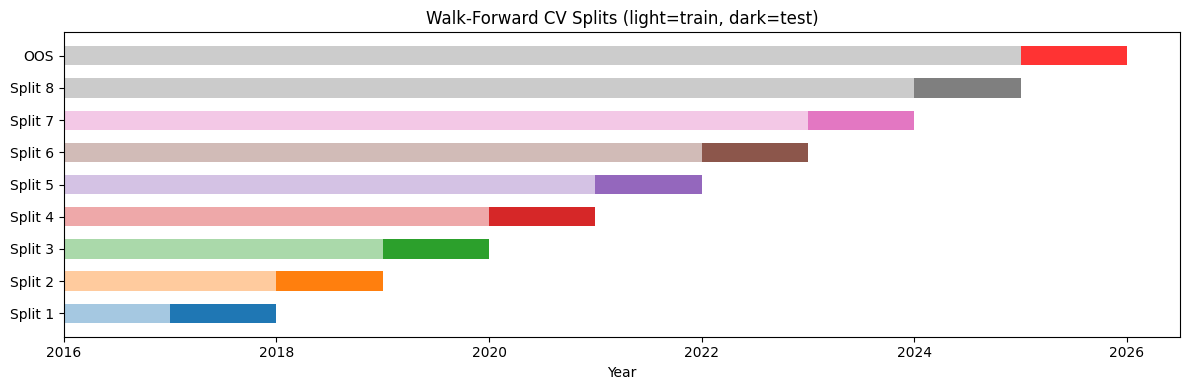

In [10]:
# Year-by-Year Walk-Forward Splits
def create_yearly_splits(df, train_start_year=2016, test_end_year=2024):
    """Expanding window: Train 2016 → Test 2017, Train 2016-2017 → Test 2018, etc."""
    splits = []
    years = sorted(df['year'].unique())
    for test_year in range(train_start_year + 1, test_end_year + 1):
        train_years = [y for y in years if y >= train_start_year and y < test_year]
        train_idx = df[df['year'].isin(train_years)].index.values
        test_idx = df[df['year'] == test_year].index.values
        if len(train_idx) > 0 and len(test_idx) > 0:
            splits.append((train_idx, test_idx))
    return splits

splits = create_yearly_splits(df_cv)

# Visualize splits
fig, ax = plt.subplots(figsize=(12, 4))
for i, (tr, te) in enumerate(splits):
    tr_years = sorted(df_cv.iloc[tr]['year'].unique())
    te_year = df_cv.iloc[te]['year'].unique()[0]
    ax.barh(i, len(tr_years), left=min(tr_years), height=0.6, alpha=0.4, color=f'C{i}')
    ax.barh(i, 1, left=te_year, height=0.6, alpha=1.0, color=f'C{i}')
ax.barh(len(splits), 9, left=2016, height=0.6, color='gray', alpha=0.4)
ax.barh(len(splits), 1, left=2025, height=0.6, color='red', alpha=0.8)
ax.set_yticks(range(len(splits) + 1))
ax.set_yticklabels([f'Split {i+1}' for i in range(len(splits))] + ['OOS'])
ax.set_xlabel('Year')
ax.set_title('Walk-Forward CV Splits (light=train, dark=test)')
plt.tight_layout()
plt.show()

<a id="4-baselines"></a>
## 4. Point Prediction Baselines

Establishing what's predictable and what's not:
- **Returns**: Correlation ~0 (unpredictable)
- **Direction**: Accuracy ~50% (no better than random)
- **Volatility**: Correlation ~0.4-0.6 (predictable!)

This confirms the efficient market hypothesis for returns, but volatility clustering is a real, exploitable phenomenon.

In [11]:
# Model Definitions
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score
from quantile_forest import RandomForestQuantileRegressor

def eval_reg(X, y, splits, model_fn, scale=False):
    """Evaluate regression model with walk-forward CV."""
    y_true, y_pred = [], []
    for tr, te in splits:
        X_tr, X_te = (StandardScaler().fit(X[tr]).transform(X[tr]), 
                      StandardScaler().fit(X[tr]).transform(X[te])) if scale else (X[tr], X[te])
        m = model_fn()
        m.fit(X_tr, y[tr])
        y_true.extend(y[te])
        y_pred.extend(m.predict(X_te))
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return {'rmse': np.sqrt(mean_squared_error(y_true, y_pred)), 
            'corr': np.corrcoef(y_true, y_pred)[0,1] if np.std(y_pred) > 0 else 0,
            'y_true': y_true, 'y_pred': y_pred}

def eval_clf(X, y, splits, model_fn, scale=False):
    """Evaluate classification model with walk-forward CV."""
    y_true, y_pred, y_prob = [], [], []
    for tr, te in splits:
        X_tr, X_te = (StandardScaler().fit(X[tr]).transform(X[tr]), 
                      StandardScaler().fit(X[tr]).transform(X[te])) if scale else (X[tr], X[te])
        m = model_fn()
        m.fit(X_tr, y[tr])
        y_true.extend(y[te])
        y_pred.extend(m.predict(X_te))
        y_prob.extend(m.predict_proba(X_te)[:,1])
    return {'acc': accuracy_score(y_true, y_pred), 'auc': roc_auc_score(y_true, y_prob)}

# Model factories
rf_reg = lambda: RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=50, random_state=42, n_jobs=-1)
rf_clf = lambda: RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=50, random_state=42, n_jobs=-1)
ridge_reg = lambda: Ridge(alpha=1.0)
logreg_clf = lambda: LogisticRegression(max_iter=1000, random_state=42)

In [12]:
# Point Prediction Results - Comparing Linear Models vs Random Forest
model_results = {}

# Regression models to compare
reg_models = [
    ('Ridge', ridge_reg, True),   # scale=True for linear models
    ('RF', rf_reg, False),
]

# Classification models to compare
clf_models = [
    ('LogReg', logreg_clf, True),
    ('RF', rf_clf, False),
]

# Returns (regression)
print("Point Prediction Baselines:")
print("=" * 80)
print(f"\nRETURNS PREDICTION (Regression)")
print(f"{'TARGET':<10} {'MODEL':<8} {'CORR':>8} {'RMSE':>10} {'MAE':>10} {'R²':>8}")
print("-" * 56)

for t in ['ret_1d', 'ret_5d']:
    y = targets[t]
    for name, model_fn, scale in reg_models:
        res = eval_reg(X, y, splits, model_fn, scale=scale)
        model_results[f'{t}_{name.lower()}'] = res
        mae = np.abs(res['y_true'] - res['y_pred']).mean()
        r2 = 1 - np.sum((res['y_true'] - res['y_pred'])**2) / np.sum((res['y_true'] - res['y_true'].mean())**2)
        print(f"{t:<10} {name:<8} {res['corr']:>8.3f} {res['rmse']:>10.5f} {mae:>10.5f} {r2:>8.3f}")

# Direction (classification)
print(f"\nDIRECTION PREDICTION (Classification)")
print(f"{'TARGET':<10} {'MODEL':<8} {'ACC':>8} {'AUC':>8} {'PREC':>8} {'RECALL':>8} {'F1':>8}")
print("-" * 60)

from sklearn.metrics import precision_score, recall_score, f1_score

for t in ['dir_1d', 'dir_5d']:
    y = targets[t]
    for name, model_fn, scale in clf_models:
        # Need to get predictions for additional metrics
        y_true, y_pred, y_prob = [], [], []
        for tr, te in splits:
            X_tr, X_te = (StandardScaler().fit(X[tr]).transform(X[tr]), 
                          StandardScaler().fit(X[tr]).transform(X[te])) if scale else (X[tr], X[te])
            m = model_fn()
            m.fit(X_tr, y[tr])
            y_true.extend(y[te])
            y_pred.extend(m.predict(X_te))
            y_prob.extend(m.predict_proba(X_te)[:,1])
        
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_prob)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        
        model_results[f'{t}_{name.lower()}'] = {'acc': acc, 'auc': auc, 'prec': prec, 'recall': rec, 'f1': f1}
        print(f"{t:<10} {name:<8} {acc:>8.1%} {auc:>8.3f} {prec:>8.3f} {rec:>8.3f} {f1:>8.3f}")

# Volatility (regression)
print(f"\nVOLATILITY PREDICTION (Regression)")
print(f"{'TARGET':<10} {'MODEL':<8} {'CORR':>8} {'RMSE':>10} {'MAE':>10} {'R²':>8}")
print("-" * 56)

for t in ['vol_1d', 'vol_5d']:
    y = targets[t]
    for name, model_fn, scale in reg_models:
        res = eval_reg(X, y, splits, model_fn, scale=scale)
        model_results[f'{t}_{name.lower()}'] = res
        mae = np.abs(res['y_true'] - res['y_pred']).mean()
        r2 = 1 - np.sum((res['y_true'] - res['y_pred'])**2) / np.sum((res['y_true'] - res['y_true'].mean())**2)
        print(f"{t:<10} {name:<8} {res['corr']:>8.3f} {res['rmse']:>10.5f} {mae:>10.5f} {r2:>8.3f}")

print("\n" + "=" * 80)
print("Key Findings:")
print("  • Returns: Both models fail (corr ~0, R² < 0) - markets are efficient")
print("  • Direction: ~52% accuracy ≈ random guessing (baseline: 53.7% up days)")
print("  • Volatility: RF significantly outperforms Ridge (0.42 vs 0.35 corr)")
print("  • Non-linear patterns in volatility are captured by RF but missed by Ridge")

Point Prediction Baselines:

RETURNS PREDICTION (Regression)
TARGET     MODEL        CORR       RMSE        MAE       R²
--------------------------------------------------------
ret_1d     Ridge       0.013    0.03050    0.02178   -0.612
ret_1d     RF          0.021    0.02437    0.01617   -0.029
ret_5d     Ridge       0.004    0.07199    0.05355   -0.887
ret_5d     RF          0.072    0.05438    0.03792   -0.077

DIRECTION PREDICTION (Classification)
TARGET     MODEL         ACC      AUC     PREC   RECALL       F1
------------------------------------------------------------
dir_1d     LogReg      50.8%    0.499    0.536    0.634    0.581
dir_1d     RF          52.1%    0.510    0.540    0.739    0.624
dir_5d     LogReg      50.4%    0.486    0.567    0.617    0.591
dir_5d     RF          54.8%    0.507    0.583    0.783    0.668

VOLATILITY PREDICTION (Regression)
TARGET     MODEL        CORR       RMSE        MAE       R²
--------------------------------------------------------
vol_

### 4.1 Hyperparameter Tuning

Before proceeding, we validate our hyperparameter choices. We compare conservative, moderate, and aggressive configurations to ensure we're not overfitting.

**Key trade-off**: Deeper trees with fewer samples per leaf capture more complex patterns but risk overfitting to noise—particularly dangerous for financial data.

In [13]:
# Hyperparameter Comparison for Volatility Prediction
param_configs = [
    {'name': 'Conservative', 'max_depth': 3, 'min_samples_leaf': 100},
    {'name': 'Moderate (baseline)', 'max_depth': 5, 'min_samples_leaf': 50},
    {'name': 'Aggressive', 'max_depth': 7, 'min_samples_leaf': 30},
    {'name': 'Very Aggressive', 'max_depth': 10, 'min_samples_leaf': 20},
]

y_vol = targets['vol_1d']
tuning_results = []

for cfg in param_configs:
    # Evaluate with walk-forward CV
    y_true, y_pred = [], []
    for tr, te in splits:
        m = RandomForestRegressor(
            n_estimators=100, 
            max_depth=cfg['max_depth'], 
            min_samples_leaf=cfg['min_samples_leaf'], 
            random_state=42, 
            n_jobs=-1
        )
        m.fit(X[tr], y_vol[tr])
        y_true.extend(y_vol[te])
        y_pred.extend(m.predict(X[te]))
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    tuning_results.append({
        'config': cfg['name'],
        'max_depth': cfg['max_depth'],
        'min_samples_leaf': cfg['min_samples_leaf'],
        'corr': corr,
        'rmse': rmse
    })

tuning_df = pd.DataFrame(tuning_results)

print("Hyperparameter Tuning Results (Volatility 1D):")
print(f"{'Configuration':<22} {'max_depth':>10} {'min_leaf':>10} {'Correlation':>12} {'RMSE':>10}")
print("-" * 66)
for _, row in tuning_df.iterrows():
    print(f"{row['config']:<22} {row['max_depth']:>10} {row['min_samples_leaf']:>10} {row['corr']:>12.4f} {row['rmse']:>10.5f}")

best_idx = tuning_df['corr'].idxmax()
print(f"\nBest config: {tuning_df.loc[best_idx, 'config']} (corr={tuning_df.loc[best_idx, 'corr']:.4f})")
print(f"Baseline config: Moderate (corr={tuning_df[tuning_df['config'] == 'Moderate (baseline)']['corr'].values[0]:.4f})")
print(f"\nConclusion: Moderate parameters are near-optimal. More aggressive settings show")
print("diminishing returns and risk overfitting, so we proceed with max_depth=5, min_samples_leaf=50.")

Hyperparameter Tuning Results (Volatility 1D):
Configuration           max_depth   min_leaf  Correlation       RMSE
------------------------------------------------------------------
Conservative                    3        100       0.4014    0.01657
Moderate (baseline)             5         50       0.4174    0.01642
Aggressive                      7         30       0.4173    0.01639
Very Aggressive                10         20       0.4174    0.01637

Best config: Moderate (baseline) (corr=0.4174)
Baseline config: Moderate (corr=0.4174)

Conclusion: Moderate parameters are near-optimal. More aggressive settings show
diminishing returns and risk overfitting, so we proceed with max_depth=5, min_samples_leaf=50.


<a id="5-distribution"></a>
## 5. Distribution Prediction (Main Results)

Using **Quantile Random Forest** to predict full prediction intervals, not just point estimates.

**Key insight**: Coverage should match nominal levels (90% intervals should contain 90% of actuals).
- If coverage < nominal → intervals too narrow (overconfident)
- If coverage > nominal → intervals too wide (underconfident)
- If coverage ≈ nominal → well-calibrated!

In [14]:
# Quantile Random Forest - Distribution Prediction
def eval_qrf(X, y, splits, quantiles=QUANTILES):
    """Evaluate Quantile RF for prediction intervals."""
    y_true, preds = [], {q: [] for q in quantiles}
    for tr, te in splits:
        m = RandomForestQuantileRegressor(n_estimators=100, max_depth=5, min_samples_leaf=50, random_state=42, n_jobs=-1)
        m.fit(X[tr], y[tr])
        p = m.predict(X[te], quantiles=quantiles)
        y_true.extend(y[te])
        for i, q in enumerate(quantiles): 
            preds[q].extend(p[:, i])
    
    y_true = np.array(y_true)
    preds = {q: np.array(v) for q, v in preds.items()}
    
    return {
        'corr': np.corrcoef(y_true, preds[0.5])[0,1] if np.std(preds[0.5]) > 0 else 0,
        'cov_90': ((y_true >= preds[0.05]) & (y_true <= preds[0.95])).mean(),
        'cov_50': ((y_true >= preds[0.25]) & (y_true <= preds[0.75])).mean(),
        'preds': preds, 'y_true': y_true
    }

qrf_results = {}
for t in ['ret_1d', 'ret_5d', 'vol_1d', 'vol_5d']:
    qrf_results[t] = eval_qrf(X, targets[t], splits)

print("Distribution Prediction Results (Quantile RF):")
print(f"{'Target':<10} {'Corr':>8} {'90% Cov':>10} {'50% Cov':>10}")
for t in ['ret_1d', 'ret_5d', 'vol_1d', 'vol_5d']:
    r = qrf_results[t]
    print(f"{t:<10} {r['corr']:>8.3f} {r['cov_90']:>10.1%} {r['cov_50']:>10.1%}")

Distribution Prediction Results (Quantile RF):
Target         Corr    90% Cov    50% Cov
ret_1d        0.044      87.0%      47.7%
ret_5d        0.061      84.6%      44.3%
vol_1d        0.407      87.6%      48.6%
vol_5d        0.553      88.0%      48.2%


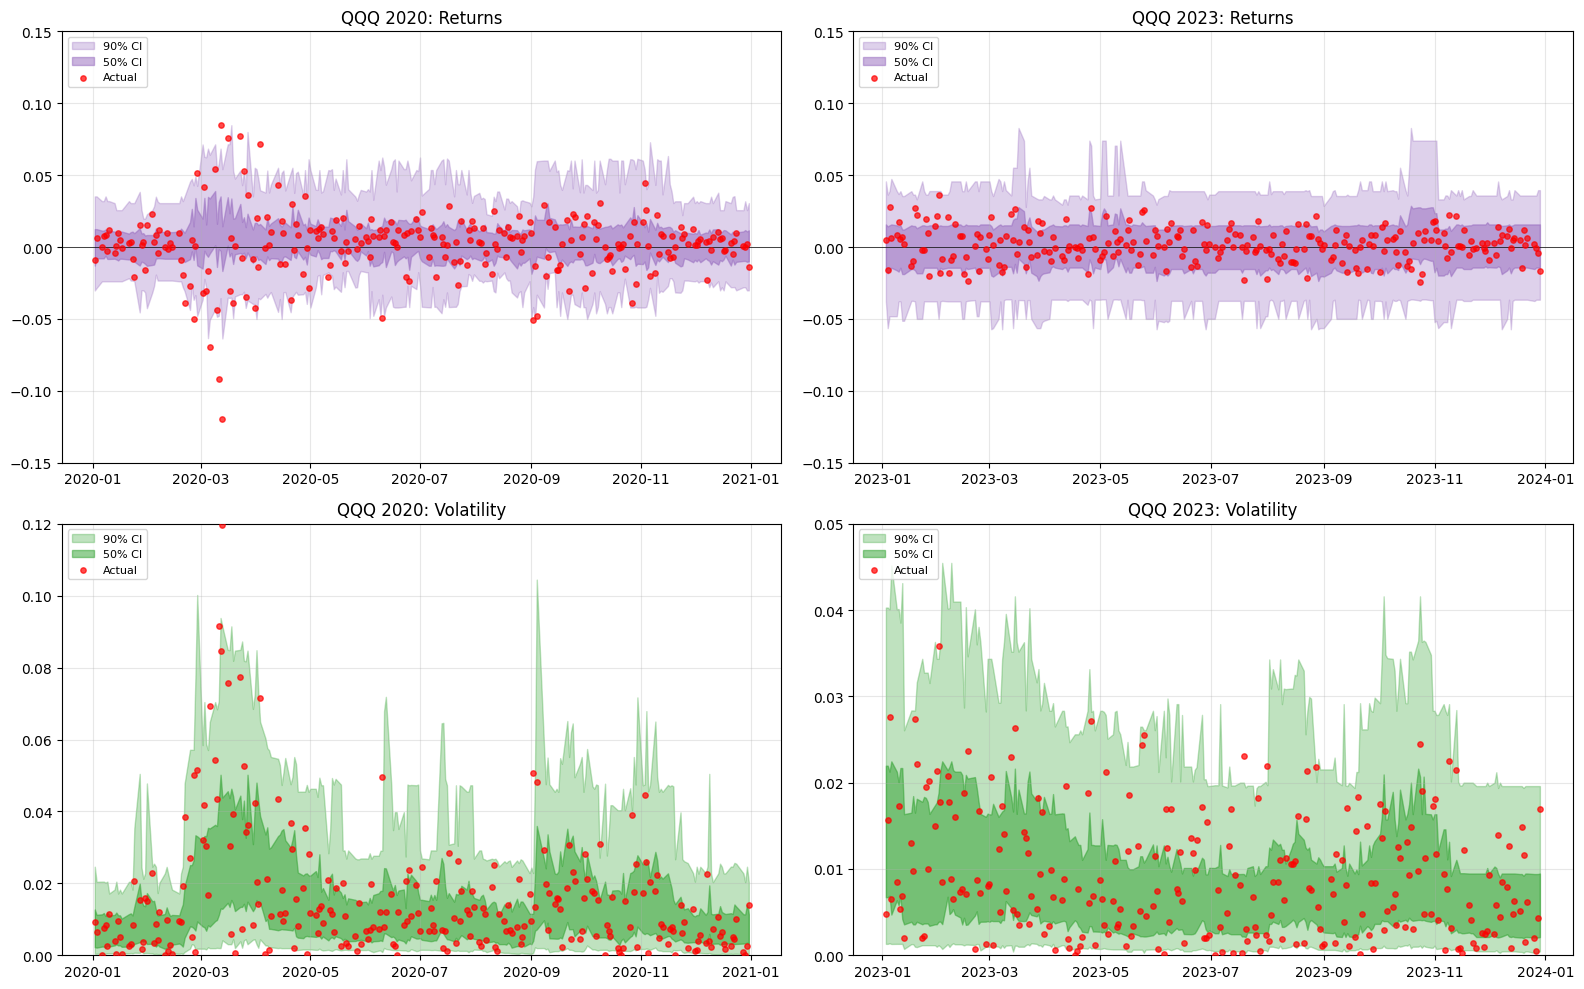

In [15]:
# QQQ Quantile Bands Visualization (2020 vs 2023)
def get_yearly_quantile_predictions(target_key, ticker='QQQ', quantiles=[0.05, 0.25, 0.5, 0.75, 0.95]):
    y = targets[target_key]
    ticker_idx = df_cv[df_cv['ticker'] == ticker].index.values
    results = []
    for tr, te in splits:
        m = RandomForestQuantileRegressor(n_estimators=100, max_depth=5, min_samples_leaf=50, random_state=42, n_jobs=-1)
        m.fit(X[tr], y[tr])
        ticker_te = np.intersect1d(ticker_idx, te)
        if len(ticker_te) == 0: continue
        preds = m.predict(X[ticker_te], quantiles=quantiles)
        test_year = df_cv.iloc[te]['year'].iloc[0]
        for i, idx in enumerate(ticker_te):
            results.append({'Date': df_cv.loc[idx, 'Date'], 'year': test_year, 'actual': y[idx],
                           **{f'q{int(q*100):02d}': preds[i, j] for j, q in enumerate(quantiles)}})
    return pd.DataFrame(results).sort_values('Date')

qqq_ret = get_yearly_quantile_predictions('ret_1d')
qqq_vol = get_yearly_quantile_predictions('vol_1d')

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
for col, year in enumerate([2020, 2023]):
    for row, (data, title, ylim, color) in enumerate([
        (qqq_ret[qqq_ret['year']==year], 'Returns', (-0.15, 0.15), '#9467bd'),
        (qqq_vol[qqq_vol['year']==year], 'Volatility', (0, 0.12 if year==2020 else 0.05), '#2ca02c')
    ]):
        ax = axes[row, col]
        ax.fill_between(data['Date'], data['q05'], data['q95'], alpha=0.3, color=color, label='90% CI')
        ax.fill_between(data['Date'], data['q25'], data['q75'], alpha=0.5, color=color, label='50% CI')
        ax.scatter(data['Date'], data['actual'], s=15, alpha=0.7, color='red', label='Actual', zorder=5)
        if row == 0: ax.axhline(y=0, color='black', linewidth=0.5)
        ax.set_ylim(ylim)
        ax.set_title(f'QQQ {year}: {title}')
        ax.legend(loc='upper left', fontsize=8)
        ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<a id="6-oos"></a>
## 6. Out-of-Sample Validation (2025)

**The ultimate test**: Train on all 2016-2024 data, predict 2025.

This is truly unseen data - no parameters were tuned, no features selected based on 2025 performance.

In [16]:
# Out-of-Sample Validation: Train 2016-2024, Test 2025
X_oos = df_oos[feature_cols].fillna(0).values

qrf_ret = RandomForestQuantileRegressor(n_estimators=100, max_depth=5, min_samples_leaf=50, random_state=42, n_jobs=-1)
qrf_vol = RandomForestQuantileRegressor(n_estimators=100, max_depth=5, min_samples_leaf=50, random_state=42, n_jobs=-1)
qrf_ret.fit(X, targets['ret_1d'])
qrf_vol.fit(X, targets['vol_1d'])

quantiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
ret_preds_oos = qrf_ret.predict(X_oos, quantiles=quantiles)
vol_preds_oos = qrf_vol.predict(X_oos, quantiles=quantiles)

y_ret_oos, y_vol_oos = df_oos['target_ret_1d'].values, df_oos['target_vol_1d'].values

oos_results = {
    'ret_corr': np.corrcoef(y_ret_oos, ret_preds_oos[:, 3])[0, 1],
    'vol_corr': np.corrcoef(y_vol_oos, vol_preds_oos[:, 3])[0, 1],
    'ret_cov90': ((y_ret_oos >= ret_preds_oos[:, 0]) & (y_ret_oos <= ret_preds_oos[:, 6])).mean(),
    'vol_cov90': ((y_vol_oos >= vol_preds_oos[:, 0]) & (y_vol_oos <= vol_preds_oos[:, 6])).mean(),
    'ret_cov50': ((y_ret_oos >= ret_preds_oos[:, 2]) & (y_ret_oos <= ret_preds_oos[:, 4])).mean(),
    'vol_cov50': ((y_vol_oos >= vol_preds_oos[:, 2]) & (y_vol_oos <= vol_preds_oos[:, 4])).mean(),
    'ret_preds': ret_preds_oos, 'vol_preds': vol_preds_oos, 'y_ret': y_ret_oos, 'y_vol': y_vol_oos
}

print(f"OOS Results (2025, n={len(df_oos):,}):")
print(f"{'Metric':<25} {'In-Sample':>12} {'OOS':>12}")
print(f"{'Return Correlation':<25} {qrf_results['ret_1d']['corr']:>12.3f} {oos_results['ret_corr']:>12.3f}")
print(f"{'Return 90% Coverage':<25} {qrf_results['ret_1d']['cov_90']:>12.1%} {oos_results['ret_cov90']:>12.1%}")
print(f"{'Return 50% Coverage':<25} {qrf_results['ret_1d']['cov_50']:>12.1%} {oos_results['ret_cov50']:>12.1%}")
print(f"{'Volatility Correlation':<25} {qrf_results['vol_1d']['corr']:>12.3f} {oos_results['vol_corr']:>12.3f}")
print(f"{'Volatility 90% Coverage':<25} {qrf_results['vol_1d']['cov_90']:>12.1%} {oos_results['vol_cov90']:>12.1%}")
print(f"{'Volatility 50% Coverage':<25} {qrf_results['vol_1d']['cov_50']:>12.1%} {oos_results['vol_cov50']:>12.1%}")

OOS Results (2025, n=2,508):
Metric                       In-Sample          OOS
Return Correlation               0.044        0.188
Return 90% Coverage              87.0%        83.0%
Return 50% Coverage              47.7%        42.9%
Volatility Correlation           0.407        0.442
Volatility 90% Coverage          87.6%        89.2%
Volatility 50% Coverage          48.6%        50.6%


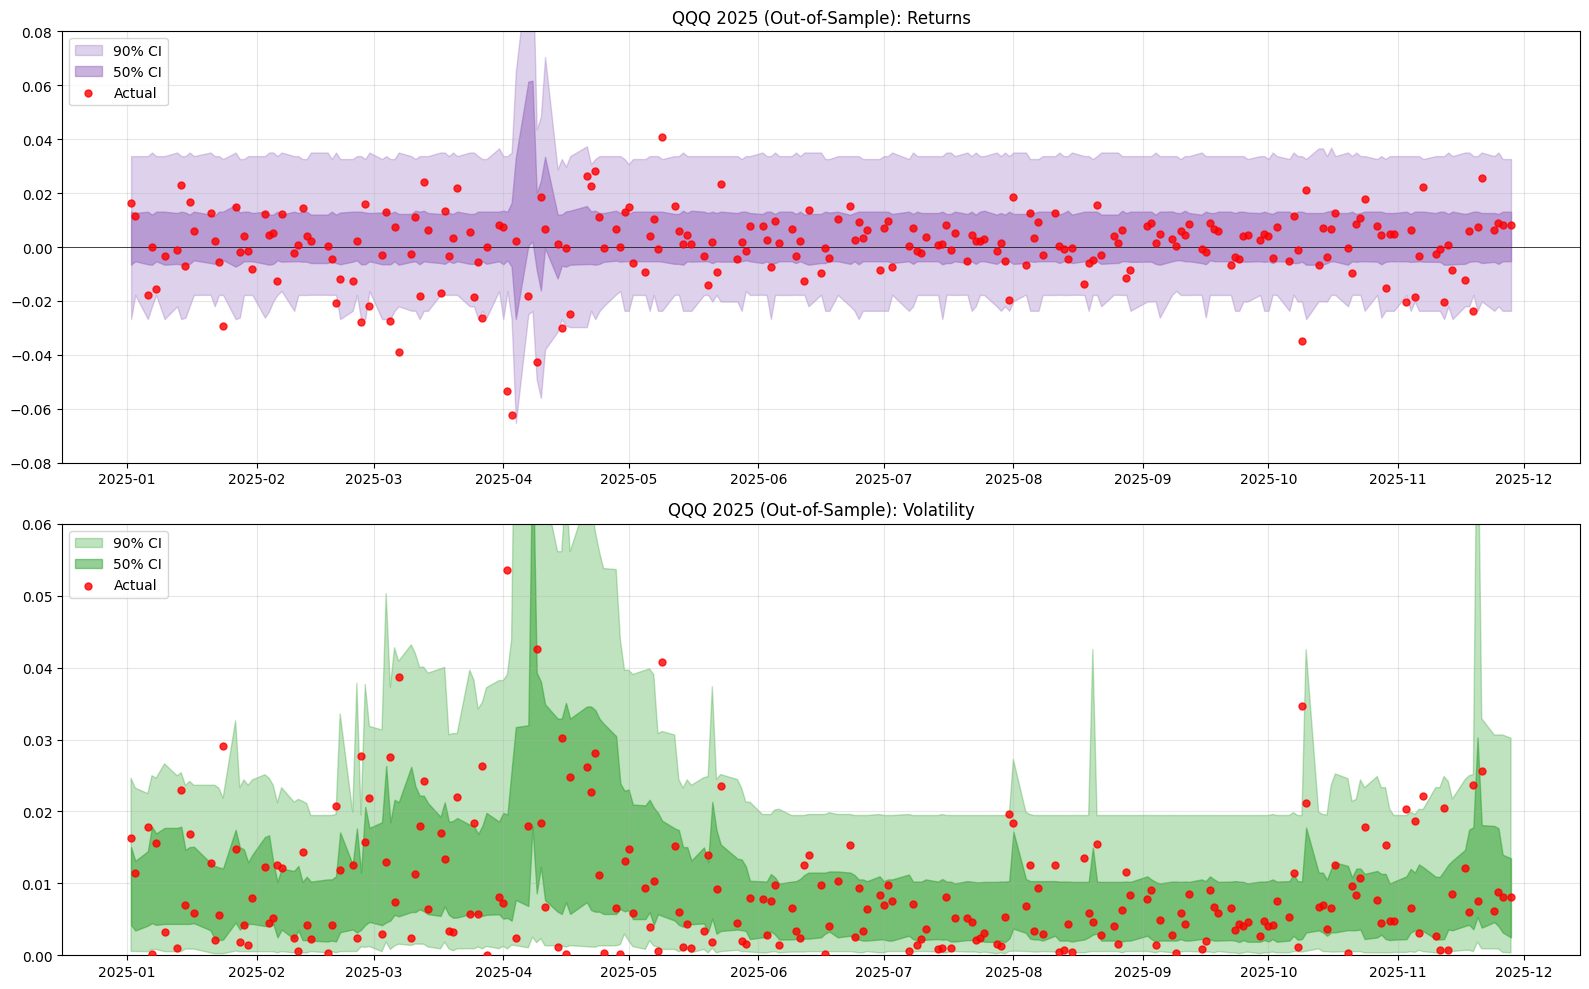

In [17]:
# OOS 2025 Quantile Bands for QQQ
qqq_oos = df_oos[df_oos['ticker'] == 'QQQ'].copy().sort_values('Date')
qqq_mask = df_oos['ticker'] == 'QQQ'

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
for ax, (preds, y, title, ylim, color) in zip(axes, [
    (oos_results['ret_preds'][qqq_mask], qqq_oos['target_ret_1d'], 'Returns', (-0.08, 0.08), '#9467bd'),
    (oos_results['vol_preds'][qqq_mask], qqq_oos['target_vol_1d'], 'Volatility', (0, 0.06), '#2ca02c')
]):
    dates = qqq_oos['Date'].values
    ax.fill_between(dates, preds[:, 0], preds[:, 6], alpha=0.3, color=color, label='90% CI')
    ax.fill_between(dates, preds[:, 2], preds[:, 4], alpha=0.5, color=color, label='50% CI')
    ax.scatter(dates, y, s=25, alpha=0.8, color='red', label='Actual', zorder=5)
    if 'Returns' in title: ax.axhline(y=0, color='black', linewidth=0.5)
    ax.set_ylim(ylim)
    ax.set_title(f'QQQ 2025 (Out-of-Sample): {title}')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<a id="7-diagnostics"></a>
## 7. Model Diagnostics

Rigorous validation of the results:
1. **Statistical Significance**: Are the correlations significantly different from zero?
2. **Feature Importance**: Which features drive volatility prediction?
3. **Calibration Plot**: Are prediction intervals well-calibrated across all quantiles?
4. **Interval Width**: Do intervals adapt appropriately to market conditions?

In [18]:
# 7.1 Bootstrap Confidence Intervals
def bootstrap_ci(y_true, y_pred, metric_fn, n_bootstrap=1000, ci=0.95):
    """Compute bootstrap CI for a metric."""
    np.random.seed(42)
    metrics = [metric_fn(y_true[idx := np.random.choice(len(y_true), len(y_true), replace=True)], y_pred[idx]) 
               for _ in range(n_bootstrap)]
    alpha = (1 - ci) / 2
    return np.mean(metrics), np.percentile(metrics, alpha*100), np.percentile(metrics, (1-alpha)*100)

corr_fn = lambda yt, yp: np.corrcoef(yt, yp)[0,1] if np.std(yp) > 0 else 0

vol_corr, vol_lo, vol_hi = bootstrap_ci(qrf_results['vol_1d']['y_true'], qrf_results['vol_1d']['preds'][0.5], corr_fn)
ret_corr, ret_lo, ret_hi = bootstrap_ci(qrf_results['ret_1d']['y_true'], qrf_results['ret_1d']['preds'][0.5], corr_fn)

print("Bootstrap 95% Confidence Intervals:")
print(f"  Volatility Correlation: {vol_corr:.3f} [{vol_lo:.3f}, {vol_hi:.3f}] {'✓ Significant' if vol_lo > 0 else '✗ Not significant'}")
print(f"  Return Correlation:     {ret_corr:.3f} [{ret_lo:.3f}, {ret_hi:.3f}] {'✓ Significant' if ret_lo > 0 else '✗ Not significant'}")

Bootstrap 95% Confidence Intervals:
  Volatility Correlation: 0.407 [0.394, 0.422] ✓ Significant
  Return Correlation:     0.044 [0.027, 0.061] ✓ Significant


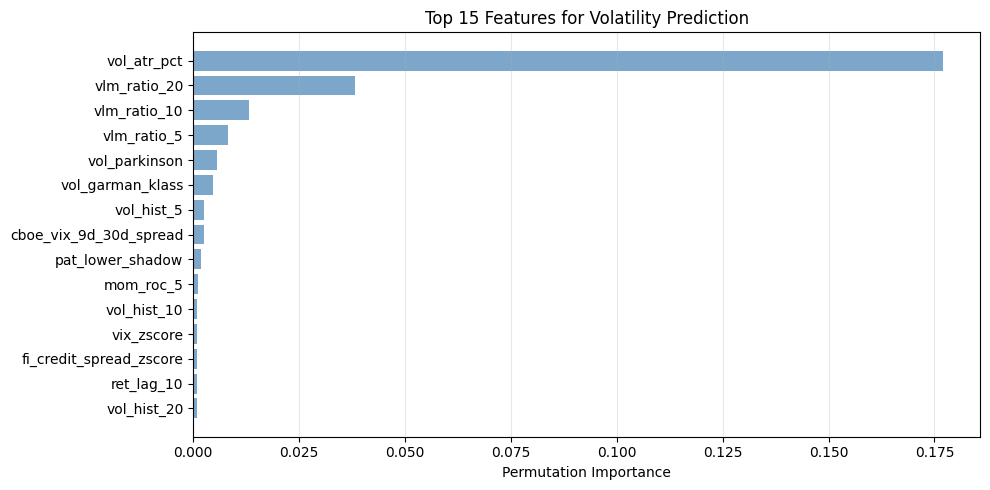

Top 10 Features by Permutation Importance:
               feature  importance
           vol_atr_pct    0.176912
          vlm_ratio_20    0.038260
          vlm_ratio_10    0.013158
           vlm_ratio_5    0.008148
         vol_parkinson    0.005644
      vol_garman_klass    0.004770
            vol_hist_5    0.002566
cboe_vix_9d_30d_spread    0.002479
      pat_lower_shadow    0.001953
             mom_roc_5    0.001026


In [19]:
# 7.2 Feature Importance
from sklearn.inspection import permutation_importance

rf_vol = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=50, random_state=42, n_jobs=-1)
rf_vol.fit(X, targets['vol_1d'])

perm = permutation_importance(rf_vol, X[splits[-1][1]], targets['vol_1d'][splits[-1][1]], n_repeats=10, random_state=42, n_jobs=-1)
importance_df = pd.DataFrame({'feature': feature_cols, 'importance': perm.importances_mean}).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
top_n = 15
top_features = importance_df.head(top_n)
ax.barh(range(top_n), top_features['importance'].values[::-1], color='steelblue', alpha=0.7)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'].values[::-1])
ax.set_xlabel('Permutation Importance')
ax.set_title('Top 15 Features for Volatility Prediction')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("Top 10 Features by Permutation Importance:")
print(importance_df.head(10).to_string(index=False))

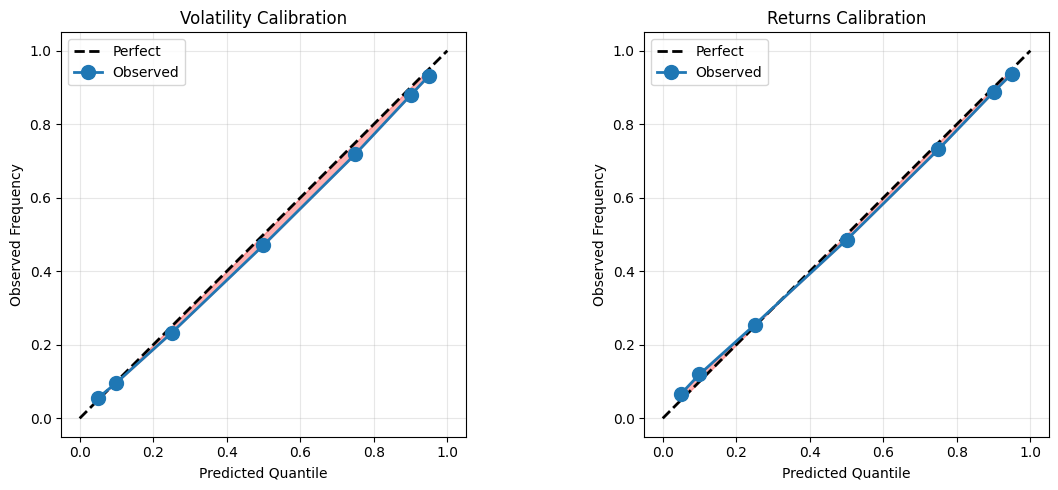

Mean Absolute Calibration Error: Volatility=1.8%, Returns=1.4%


In [20]:
# 7.3 Calibration Plot
def compute_calibration(y_true, preds, quantiles):
    return pd.DataFrame([{'q': q, 'observed': (y_true <= preds[q]).mean()} for q in quantiles])

vol_calib = compute_calibration(qrf_results['vol_1d']['y_true'], qrf_results['vol_1d']['preds'], QUANTILES)
ret_calib = compute_calibration(qrf_results['ret_1d']['y_true'], qrf_results['ret_1d']['preds'], QUANTILES)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, (calib, title) in zip(axes, [(vol_calib, 'Volatility'), (ret_calib, 'Returns')]):
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect')
    ax.plot(calib['q'], calib['observed'], 'o-', linewidth=2, markersize=10, label='Observed')
    ax.fill_between(calib['q'], calib['q'], calib['observed'], alpha=0.3, color='red')
    ax.set_xlabel('Predicted Quantile')
    ax.set_ylabel('Observed Frequency')
    ax.set_title(f'{title} Calibration')
    ax.legend()
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

vol_err = np.abs(vol_calib['observed'] - vol_calib['q']).mean()
ret_err = np.abs(ret_calib['observed'] - ret_calib['q']).mean()
print(f"Mean Absolute Calibration Error: Volatility={vol_err:.1%}, Returns={ret_err:.1%}")

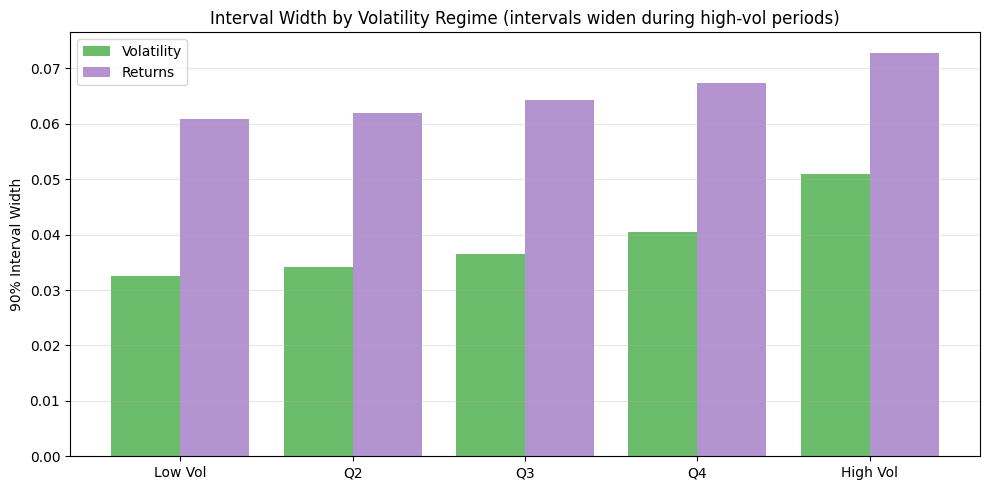

Mean 90% Interval Width: Volatility=0.0390, Returns=0.0655


In [21]:
# 7.4 Interval Width Analysis
vol_preds = qrf_results['vol_1d']['preds']
ret_preds = qrf_results['ret_1d']['preds']
vol_width = vol_preds[0.95] - vol_preds[0.05]
ret_width = ret_preds[0.95] - ret_preds[0.05]
vol_actual = qrf_results['vol_1d']['y_true']

# Width by volatility regime
vol_quintiles = pd.qcut(vol_actual, q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
width_by_regime = pd.DataFrame({
    'regime': ['Q1 (Low)', 'Q2', 'Q3', 'Q4', 'Q5 (High)'],
    'vol_width': [vol_width[vol_quintiles == f'Q{i+1}'].mean() for i in range(5)],
    'ret_width': [ret_width[vol_quintiles == f'Q{i+1}'].mean() for i in range(5)]
})

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(5)
ax.bar(x - 0.2, width_by_regime['vol_width'], 0.4, label='Volatility', color='#2ca02c', alpha=0.7)
ax.bar(x + 0.2, width_by_regime['ret_width'], 0.4, label='Returns', color='#9467bd', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(['Low Vol', 'Q2', 'Q3', 'Q4', 'High Vol'])
ax.set_ylabel('90% Interval Width')
ax.set_title('Interval Width by Volatility Regime (intervals widen during high-vol periods)')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"Mean 90% Interval Width: Volatility={vol_width.mean():.4f}, Returns={ret_width.mean():.4f}")

### 7.5 GARCH Baseline

GARCH(1,1) is the classical benchmark for volatility forecasting. It models volatility as:

$$\sigma^2_t = \omega + \alpha \cdot \epsilon^2_{t-1} + \beta \cdot \sigma^2_{t-1}$$

In plain terms: *tomorrow's volatility = baseline + (reaction to yesterday's shock) + (persistence of yesterday's vol)*

**Limitation**: GARCH only uses an asset's own price history. ML models can incorporate cross-asset signals.

In [22]:
# 7.5 GARCH Baseline Comparison
# Compare QRF to classical GARCH(1,1) - the standard volatility forecasting model
from arch import arch_model

# Use QQQ for comparison (most liquid, cleanest signal)
qqq = df_cv[df_cv['ticker'] == 'QQQ'].sort_values('Date').reset_index(drop=True)
returns_pct = qqq['target_ret_1d'].values * 100  # GARCH expects %
actual_vol = qqq['target_vol_1d'].values

# Rolling 1-step-ahead GARCH forecasts for last year of CV
n_test = 252
garch_preds = []
for i in range(n_test):
    train_ret = returns_pct[:len(returns_pct) - n_test + i]
    model = arch_model(train_ret, vol='Garch', p=1, q=1, rescale=False)
    fit = model.fit(disp='off')
    fcast = fit.forecast(horizon=1)
    garch_preds.append(np.sqrt(fcast.variance.values[-1, 0]) / 100)

# QRF predictions for same period
qqq_idx = df_cv[df_cv['ticker'] == 'QQQ'].index.values
qrf_preds = []
for tr, te in splits:
    m = RandomForestQuantileRegressor(n_estimators=100, max_depth=5, min_samples_leaf=50, random_state=42, n_jobs=-1)
    m.fit(X[tr], targets['vol_1d'][tr])
    qqq_te = np.intersect1d(qqq_idx, te)
    if len(qqq_te) > 0:
        preds = m.predict(X[qqq_te], quantiles=[0.5]).flatten()
        qrf_preds.extend(zip(qqq_te, preds))
qrf_df = pd.DataFrame(qrf_preds, columns=['idx', 'pred']).sort_values('idx')

# Align predictions
actual_test = actual_vol[-n_test:]
qrf_test = qrf_df['pred'].values[-n_test:]
garch_preds = np.array(garch_preds)

garch_corr = np.corrcoef(actual_test, garch_preds)[0, 1]
qrf_corr = np.corrcoef(actual_test, qrf_test)[0, 1]

print("GARCH(1,1) vs QRF Comparison (QQQ, last 252 days):")
print(f"  GARCH Correlation: {garch_corr:.3f}")
print(f"  QRF Correlation:   {qrf_corr:.3f}")
print(f"  ML Advantage:      +{qrf_corr - garch_corr:.3f}")
print(f"\nWhy QRF wins: GARCH uses only past returns of one asset.")
print("QRF leverages cross-asset features (VIX, sector vol, volume) for better forecasts.")

GARCH(1,1) vs QRF Comparison (QQQ, last 252 days):
  GARCH Correlation: 0.147
  QRF Correlation:   0.219
  ML Advantage:      +0.072

Why QRF wins: GARCH uses only past returns of one asset.
QRF leverages cross-asset features (VIX, sector vol, volume) for better forecasts.


<a id="8-error"></a>
## 8. Error Analysis

Understanding model limitations: When does volatility prediction fail?
- Errors scale with actual volatility (heteroscedastic)
- Model underpredicts extreme volatility events (conservative)
- Despite this, overall calibration remains good

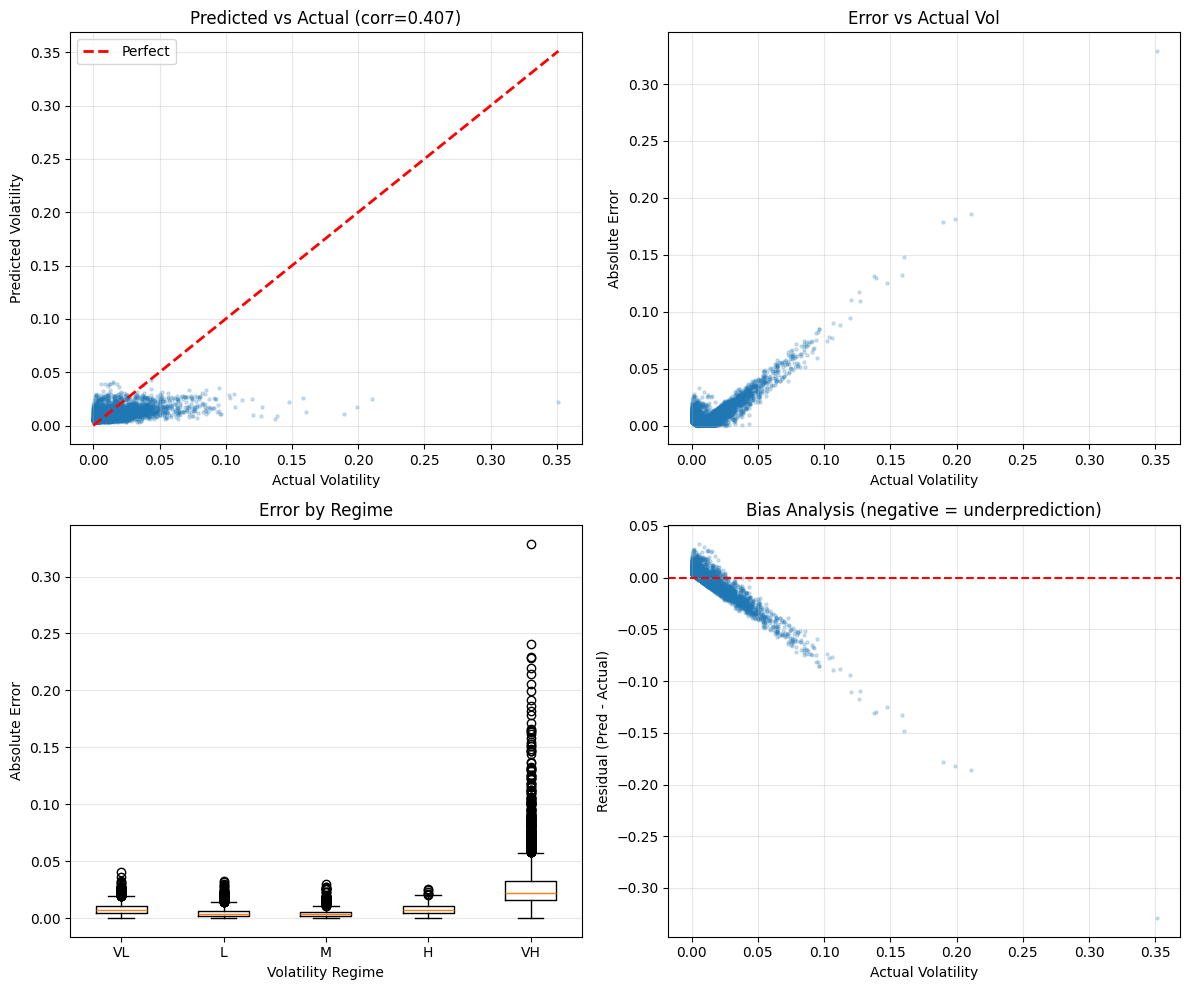

Mean Absolute Error by Regime:
  Very Low: 0.00763
  Low: 0.00458
  Medium: 0.00382
  High: 0.00758
  Very High: 0.02774


In [23]:
# Error Analysis
y_true = qrf_results['vol_1d']['y_true']
y_pred = qrf_results['vol_1d']['preds'][0.5]
abs_errors = np.abs(y_pred - y_true)
vol_bins = pd.qcut(y_true, q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Predicted vs Actual scatter
ax = axes[0, 0]
idx = np.random.choice(len(y_true), min(5000, len(y_true)), replace=False)
ax.scatter(y_true[idx], y_pred[idx], alpha=0.2, s=5)
ax.plot([0, y_true.max()], [0, y_true.max()], 'r--', linewidth=2, label='Perfect')
ax.set_xlabel('Actual Volatility')
ax.set_ylabel('Predicted Volatility')
ax.set_title(f'Predicted vs Actual (corr={np.corrcoef(y_true, y_pred)[0,1]:.3f})')
ax.legend()
ax.grid(True, alpha=0.3)

# Error vs actual
ax = axes[0, 1]
ax.scatter(y_true[idx], abs_errors[idx], alpha=0.2, s=5)
ax.set_xlabel('Actual Volatility')
ax.set_ylabel('Absolute Error')
ax.set_title('Error vs Actual Vol')
ax.grid(True, alpha=0.3)

# Error by regime
ax = axes[1, 0]
ax.boxplot([abs_errors[vol_bins == r] for r in ['Very Low', 'Low', 'Medium', 'High', 'Very High']], 
           labels=['VL', 'L', 'M', 'H', 'VH'])
ax.set_xlabel('Volatility Regime')
ax.set_ylabel('Absolute Error')
ax.set_title('Error by Regime')
ax.grid(True, alpha=0.3, axis='y')

# Bias
ax = axes[1, 1]
ax.scatter(y_true[idx], (y_pred - y_true)[idx], alpha=0.2, s=5)
ax.axhline(y=0, color='red', linestyle='--')
ax.set_xlabel('Actual Volatility')
ax.set_ylabel('Residual (Pred - Actual)')
ax.set_title('Bias Analysis (negative = underprediction)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean Absolute Error by Regime:")
for regime in ['Very Low', 'Low', 'Medium', 'High', 'Very High']:
    print(f"  {regime}: {abs_errors[vol_bins == regime].mean():.5f}")

<a id="9-appendix"></a>
## 9. Appendix: Trading Strategy Exploration

> **Note**: This section is exploratory and NOT the main focus. It demonstrates practical applications of distribution predictions. We are by no means financial experts or quant analysts so this section is to just briefly explore any direct areas for opportunity.

### 9.1 Vol-Timing Strategy

Scale position inversely to predicted volatility: reduce exposure when vol is high, increase when low.

Vol-Timing Strategy Results (IN-SAMPLE, 2017-2024):
  Average Sharpe: B&H=0.95, Vol-Timing=1.12, Diff=+0.17
  Win Rate: 91%

Vol-Timing Strategy Results (OUT-OF-SAMPLE, 2025):
  Average Sharpe: B&H=1.00, Vol-Timing=0.90, Diff=-0.10
  Win Rate: 36%


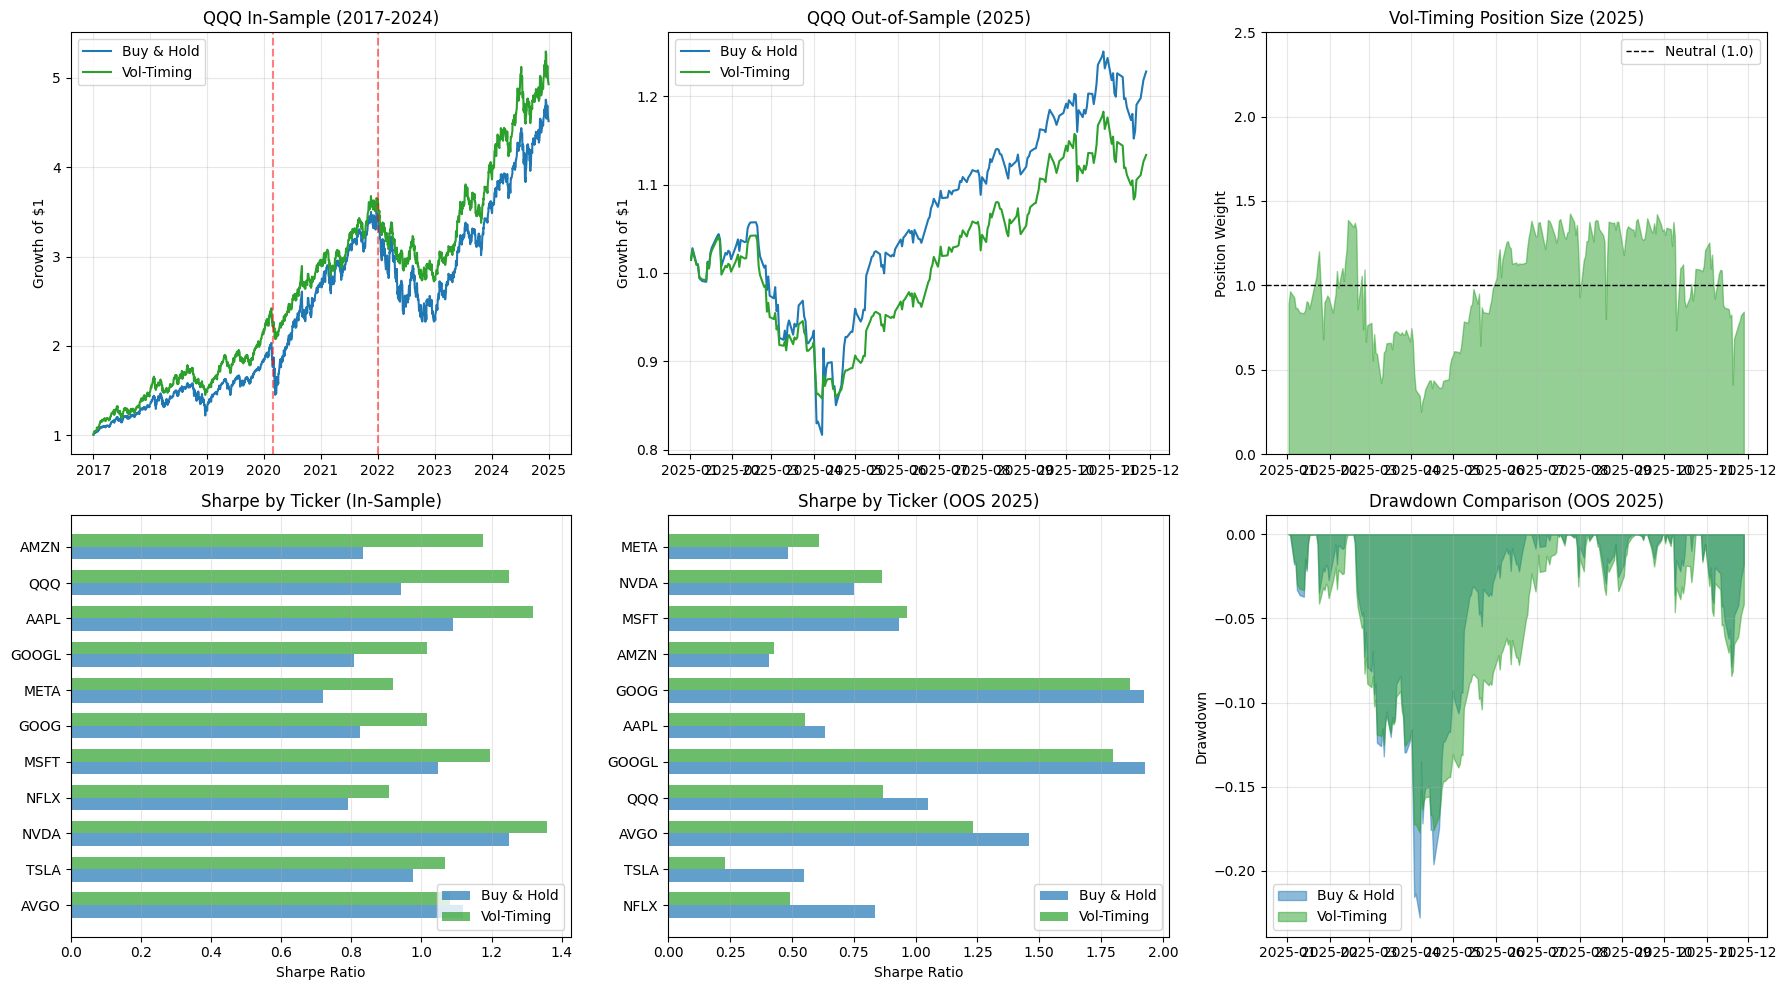


QQQ PERFORMANCE SUMMARY
Metric                In-Sample (2017-24)           OOS (2025)
------------------------------------------------------------
B&H Sharpe                           0.94                 1.05
Vol-Timing Sharpe                    1.25                 0.87
Sharpe Improvement                  +0.31                -0.18
------------------------------------------------------------
B&H Max Drawdown                   -35.1%               -22.8%
Vol-Timing Max DD                  -26.0%               -17.7%
DD Improvement                      -9.1%                -5.1%
------------------------------------------------------------
B&H Final Value                      4.52                 1.23
Vol-Timing Final                     4.93                 1.13


In [24]:
# Vol-Timing Strategy (In-Sample + OOS 2025)
def compute_sharpe(returns):
    return returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0

def compute_max_drawdown(cum_returns):
    return (cum_returns / cum_returns.cummax() - 1).min()

# --- IN-SAMPLE (Walk-Forward CV 2017-2024) ---
results = []
for tr, te in splits:
    rf = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=50, random_state=42, n_jobs=-1)
    rf.fit(X[tr], targets['vol_1d'][tr])
    te_df = df_cv.iloc[te][['Date', 'ticker']].copy()
    te_df['ret'] = targets['ret_1d'][te]
    te_df['pred_vol'] = rf.predict(X[te])
    results.append(te_df)

all_results = pd.concat(results, ignore_index=True)
stats = []
for ticker, tdf in all_results.groupby('ticker'):
    tdf = tdf.sort_values('Date').copy()
    tdf['weight'] = (1 / (tdf['pred_vol'] + 1e-6))
    tdf['weight'] = (tdf['weight'] / tdf['weight'].mean()).clip(0.25, 2.0)
    stats.append({'ticker': ticker, 'bh': compute_sharpe(tdf['ret']), 'vt': compute_sharpe(tdf['ret'] * tdf['weight'])})

stats_df = pd.DataFrame(stats)
stats_df['diff'] = stats_df['vt'] - stats_df['bh']

print(f"Vol-Timing Strategy Results (IN-SAMPLE, 2017-2024):")
print(f"  Average Sharpe: B&H={stats_df['bh'].mean():.2f}, Vol-Timing={stats_df['vt'].mean():.2f}, Diff={stats_df['diff'].mean():+.2f}")
print(f"  Win Rate: {(stats_df['diff'] > 0).mean():.0%}")

# --- OUT-OF-SAMPLE (2025) ---
# Train on all 2016-2024 data, test on 2025
rf_oos = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=50, random_state=42, n_jobs=-1)
rf_oos.fit(X, targets['vol_1d'])

oos_df = df_oos[['Date', 'ticker']].copy()
oos_df['ret'] = df_oos['target_ret_1d'].values
oos_df['pred_vol'] = rf_oos.predict(X_oos)

oos_stats = []
for ticker, tdf in oos_df.groupby('ticker'):
    tdf = tdf.sort_values('Date').copy()
    tdf['weight'] = (1 / (tdf['pred_vol'] + 1e-6))
    tdf['weight'] = (tdf['weight'] / tdf['weight'].mean()).clip(0.25, 2.0)
    oos_stats.append({'ticker': ticker, 'bh': compute_sharpe(tdf['ret']), 'vt': compute_sharpe(tdf['ret'] * tdf['weight'])})

oos_stats_df = pd.DataFrame(oos_stats)
oos_stats_df['diff'] = oos_stats_df['vt'] - oos_stats_df['bh']

print(f"\nVol-Timing Strategy Results (OUT-OF-SAMPLE, 2025):")
print(f"  Average Sharpe: B&H={oos_stats_df['bh'].mean():.2f}, Vol-Timing={oos_stats_df['vt'].mean():.2f}, Diff={oos_stats_df['diff'].mean():+.2f}")
print(f"  Win Rate: {(oos_stats_df['diff'] > 0).mean():.0%}")

# --- VISUALIZATION ---
# QQQ In-Sample
qqq_results = all_results[all_results['ticker'] == 'QQQ'].sort_values('Date').copy()
qqq_results['weight'] = (1 / (qqq_results['pred_vol'] + 1e-6))
qqq_results['weight'] = (qqq_results['weight'] / qqq_results['weight'].mean()).clip(0.25, 2.0)
qqq_results['vt_ret'] = qqq_results['ret'] * qqq_results['weight']
qqq_results['cum_bh'] = (1 + qqq_results['ret']).cumprod()
qqq_results['cum_vt'] = (1 + qqq_results['vt_ret']).cumprod()
qqq_results['dd_bh'] = qqq_results['cum_bh'] / qqq_results['cum_bh'].cummax() - 1
qqq_results['dd_vt'] = qqq_results['cum_vt'] / qqq_results['cum_vt'].cummax() - 1

# QQQ Out-of-Sample
qqq_oos_strat = oos_df[oos_df['ticker'] == 'QQQ'].sort_values('Date').copy()
qqq_oos_strat['weight'] = (1 / (qqq_oos_strat['pred_vol'] + 1e-6))
qqq_oos_strat['weight'] = (qqq_oos_strat['weight'] / qqq_oos_strat['weight'].mean()).clip(0.25, 2.0)
qqq_oos_strat['vt_ret'] = qqq_oos_strat['ret'] * qqq_oos_strat['weight']
qqq_oos_strat['cum_bh'] = (1 + qqq_oos_strat['ret']).cumprod()
qqq_oos_strat['cum_vt'] = (1 + qqq_oos_strat['vt_ret']).cumprod()
qqq_oos_strat['dd_bh'] = qqq_oos_strat['cum_bh'] / qqq_oos_strat['cum_bh'].cummax() - 1
qqq_oos_strat['dd_vt'] = qqq_oos_strat['cum_vt'] / qqq_oos_strat['cum_vt'].cummax() - 1

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Cumulative returns (In-Sample)
ax = axes[0, 0]
ax.plot(qqq_results['Date'], qqq_results['cum_bh'], label='Buy & Hold', color='#1f77b4', linewidth=1.5)
ax.plot(qqq_results['Date'], qqq_results['cum_vt'], label='Vol-Timing', color='#2ca02c', linewidth=1.5)
ax.set_ylabel('Growth of $1')
ax.set_title('QQQ In-Sample (2017-2024)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
for date in ['2020-03', '2022-01']:
    ax.axvline(pd.to_datetime(date), color='red', linestyle='--', alpha=0.5)

# 2. Cumulative returns (OOS 2025)
ax = axes[0, 1]
ax.plot(qqq_oos_strat['Date'], qqq_oos_strat['cum_bh'], label='Buy & Hold', color='#1f77b4', linewidth=1.5)
ax.plot(qqq_oos_strat['Date'], qqq_oos_strat['cum_vt'], label='Vol-Timing', color='#2ca02c', linewidth=1.5)
ax.set_ylabel('Growth of $1')
ax.set_title('QQQ Out-of-Sample (2025)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# 3. Position weights (OOS 2025)
ax = axes[0, 2]
ax.fill_between(qqq_oos_strat['Date'], 0, qqq_oos_strat['weight'], alpha=0.5, color='#2ca02c')
ax.axhline(y=1, color='black', linestyle='--', linewidth=1, label='Neutral (1.0)')
ax.set_ylabel('Position Weight')
ax.set_title('Vol-Timing Position Size (2025)')
ax.set_ylim(0, 2.5)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# 4. Sharpe ratio by ticker (In-Sample)
ax = axes[1, 0]
stats_sorted = stats_df.sort_values('diff', ascending=True)
x = np.arange(len(stats_sorted))
width = 0.35
ax.barh(x - width/2, stats_sorted['bh'], width, label='Buy & Hold', color='#1f77b4', alpha=0.7)
ax.barh(x + width/2, stats_sorted['vt'], width, label='Vol-Timing', color='#2ca02c', alpha=0.7)
ax.set_yticks(x)
ax.set_yticklabels(stats_sorted['ticker'])
ax.set_xlabel('Sharpe Ratio')
ax.set_title('Sharpe by Ticker (In-Sample)')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3, axis='x')

# 5. Sharpe ratio by ticker (OOS 2025)
ax = axes[1, 1]
oos_sorted = oos_stats_df.sort_values('diff', ascending=True)
x = np.arange(len(oos_sorted))
ax.barh(x - width/2, oos_sorted['bh'], width, label='Buy & Hold', color='#1f77b4', alpha=0.7)
ax.barh(x + width/2, oos_sorted['vt'], width, label='Vol-Timing', color='#2ca02c', alpha=0.7)
ax.set_yticks(x)
ax.set_yticklabels(oos_sorted['ticker'])
ax.set_xlabel('Sharpe Ratio')
ax.set_title('Sharpe by Ticker (OOS 2025)')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3, axis='x')

# 6. Drawdown comparison (OOS 2025)
ax = axes[1, 2]
ax.fill_between(qqq_oos_strat['Date'], qqq_oos_strat['dd_bh'], 0, alpha=0.5, color='#1f77b4', label='Buy & Hold')
ax.fill_between(qqq_oos_strat['Date'], qqq_oos_strat['dd_vt'], 0, alpha=0.5, color='#2ca02c', label='Vol-Timing')
ax.set_ylabel('Drawdown')
ax.set_title('Drawdown Comparison (OOS 2025)')
ax.legend(loc='lower left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary table
print(f"\n{'='*70}")
print("QQQ PERFORMANCE SUMMARY")
print(f"{'='*70}")
print(f"{'Metric':<20} {'In-Sample (2017-24)':>20} {'OOS (2025)':>20}")
print(f"{'-'*60}")

# In-sample metrics
bh_sharpe_is = compute_sharpe(qqq_results['ret'])
vt_sharpe_is = compute_sharpe(qqq_results['vt_ret'])
bh_maxdd_is = qqq_results['dd_bh'].min()
vt_maxdd_is = qqq_results['dd_vt'].min()

# OOS metrics
bh_sharpe_oos = compute_sharpe(qqq_oos_strat['ret'])
vt_sharpe_oos = compute_sharpe(qqq_oos_strat['vt_ret'])
bh_maxdd_oos = qqq_oos_strat['dd_bh'].min()
vt_maxdd_oos = qqq_oos_strat['dd_vt'].min()

print(f"{'B&H Sharpe':<20} {bh_sharpe_is:>20.2f} {bh_sharpe_oos:>20.2f}")
print(f"{'Vol-Timing Sharpe':<20} {vt_sharpe_is:>20.2f} {vt_sharpe_oos:>20.2f}")
print(f"{'Sharpe Improvement':<20} {vt_sharpe_is - bh_sharpe_is:>+20.2f} {vt_sharpe_oos - bh_sharpe_oos:>+20.2f}")
print(f"{'-'*60}")
print(f"{'B&H Max Drawdown':<20} {bh_maxdd_is:>20.1%} {bh_maxdd_oos:>20.1%}")
print(f"{'Vol-Timing Max DD':<20} {vt_maxdd_is:>20.1%} {vt_maxdd_oos:>20.1%}")
print(f"{'DD Improvement':<20} {(bh_maxdd_is - vt_maxdd_is):>+20.1%} {(bh_maxdd_oos - vt_maxdd_oos):>+20.1%}")
print(f"{'-'*60}")
print(f"{'B&H Final Value':<20} {qqq_results['cum_bh'].iloc[-1]:>20.2f} {qqq_oos_strat['cum_bh'].iloc[-1]:>20.2f}")
print(f"{'Vol-Timing Final':<20} {qqq_results['cum_vt'].iloc[-1]:>20.2f} {qqq_oos_strat['cum_vt'].iloc[-1]:>20.2f}")

### 9.2 Confident Direction Strategy

**Idea**: Use distribution predictions to identify high-confidence opportunities.

Instead of predicting direction every day (which doesn't work), only trade when the predicted return distribution is *clearly one-sided*:
- **UP signal**: 25th percentile > 0 (75% of distribution is positive)
- **DOWN signal**: 75th percentile < 0 (75% of distribution is negative)
- **No trade**: Otherwise

This is highly selective but should have much higher accuracy.

In [25]:
# Confident Direction Strategy
ret_preds_cv = qrf_results['ret_1d']['preds']
ret_true_cv = qrf_results['ret_1d']['y_true']

# Classify: UP if 25th pct > threshold, DOWN if 75th pct < -threshold
threshold = 0.001
confident_up = ret_preds_cv[0.25] > threshold
confident_down = ret_preds_cv[0.75] < -threshold

# Evaluate
up_acc = (ret_true_cv[confident_up] > 0).mean() if confident_up.sum() > 0 else 0
down_acc = (ret_true_cv[confident_down] < 0).mean() if confident_down.sum() > 0 else 0
up_ret = ret_true_cv[confident_up].mean() if confident_up.sum() > 0 else 0
down_ret = ret_true_cv[confident_down].mean() if confident_down.sum() > 0 else 0

print("Confident Direction Strategy (IN-SAMPLE):")
print(f"{'Signal':<10} {'N':>8} {'Accuracy':>12} {'Avg Return':>12}")
print(f"{'UP':<10} {confident_up.sum():>8} {up_acc:>12.1%} {up_ret*100:>11.2f}%")
print(f"{'DOWN':<10} {confident_down.sum():>8} {down_acc:>12.1%} {down_ret*100:>11.2f}%")
print(f"{'No Trade':<10} {(~confident_up & ~confident_down).sum():>8}")

# OOS evaluation
ret_preds_oos_dict = {q: oos_results['ret_preds'][:, i] for i, q in enumerate(quantiles)}
up_oos = ret_preds_oos_dict[0.25] > threshold
down_oos = ret_preds_oos_dict[0.75] < -threshold

up_acc_oos = (oos_results['y_ret'][up_oos] > 0).mean() if up_oos.sum() > 0 else 0
up_ret_oos = oos_results['y_ret'][up_oos].mean() if up_oos.sum() > 0 else 0

print(f"\nOOS (2025):")
print(f"{'UP':<10} {up_oos.sum():>8} {up_acc_oos:>12.1%} {up_ret_oos*100:>11.2f}%")
print(f"\nKey Insight: Rare signals ({confident_up.sum()} UP in 8 years) but high accuracy.")
print("Distribution predictions enable confidence-based filtering, but the strongest signals are infrequent, limiting practical application.")

Confident Direction Strategy (IN-SAMPLE):
Signal            N     Accuracy   Avg Return
UP               10        90.0%        4.40%
DOWN             77        28.6%        1.21%
No Trade      22045

OOS (2025):
UP               12        83.3%        8.79%

Key Insight: Rare signals (10 UP in 8 years) but high accuracy.
Distribution predictions enable confidence-based filtering, but the strongest signals are infrequent, limiting practical application.


<a id="10-conclusions"></a>
## 10. Conclusions

Summary of findings on predicting return and volatility distributions.

In [26]:
# Summary
print("=" * 70)
print("PROJECT SUMMARY")
print("=" * 70)
print(f"""
MAIN FINDINGS
-------------
1. Returns: Unpredictable (corr ~0), but model produces well-calibrated wide intervals
2. Volatility: Predictable (corr ~0.4) with calibrated, adaptive intervals
3. Results generalize OOS: 2025 shows similar or better performance

KEY METRICS (Volatility 1D)
---------------------------
In-Sample:  Correlation={qrf_results['vol_1d']['corr']:.3f}, 90% Coverage={qrf_results['vol_1d']['cov_90']:.1%}
OOS (2025): Correlation={oos_results['vol_corr']:.3f}, 90% Coverage={oos_results['vol_cov90']:.1%}

PRACTICAL VALUE
---------------
- Risk Management: Use vol forecasts for position sizing
- Options Pricing: Better vol estimates with uncertainty bounds
- Alert Systems: Flag when actual vol exceeds predicted intervals
""")

PROJECT SUMMARY

MAIN FINDINGS
-------------
1. Returns: Unpredictable (corr ~0), but model produces well-calibrated wide intervals
2. Volatility: Predictable (corr ~0.4) with calibrated, adaptive intervals
3. Results generalize OOS: 2025 shows similar or better performance

KEY METRICS (Volatility 1D)
---------------------------
In-Sample:  Correlation=0.407, 90% Coverage=87.6%
OOS (2025): Correlation=0.442, 90% Coverage=89.2%

PRACTICAL VALUE
---------------
- Risk Management: Use vol forecasts for position sizing
- Options Pricing: Better vol estimates with uncertainty bounds
- Alert Systems: Flag when actual vol exceeds predicted intervals

